In [1]:
import librosa
import librosa.display
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy import signal
from tqdm.notebook import tqdm
from glob import glob
import gc

import tensorflow as tf
import keras
from keras import layers, losses
from keras.models import Model, load_model
import keras.backend as K

from keras.losses import binary_crossentropy, mean_squared_error

from keras.layers import Input,Conv2D, Layer, UpSampling2D, MaxPooling2D, Dense, Flatten, Lambda, GlobalAveragePooling2D, Conv2DTranspose, Reshape, BatchNormalization, Dropout, ELU, ReLU
from tensorflow.keras.utils import plot_model
import pdb

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

C:\Users\GP65\anaconda3\envs\py39\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [18]:
train_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/MEL_dbscale/*')[:-100]
test_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/MEL_dbscale/*')[-100:]

BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
min_level_db = -80 

In [19]:
def data_loader(path):
    path = bytes.decode(path.numpy())
    spec = tf.cast(np.load(path),tf.float32)
    spec = tf.expand_dims(spec,axis=-1)
    return spec

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db


In [20]:
def get_dataset(data_paths):
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    dataset = dataset.map(lambda x : tf.py_function(data_loader, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x : tf.py_function(normalize, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [21]:
X_train = get_dataset(train_paths)
X_test = get_dataset(test_paths)

### Creating the model

In [44]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        self.latent_dim = latent_dim
        
        ## Creating Encoder
        encoder_inputs = keras.Input(shape=(128, 431, 1))
        x = layers.Conv2D(4, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(1024, activation="relu")(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        
        self.encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        
        
        ## Creating Decoder
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(1024, activation="relu")(latent_inputs)
        x = layers.Dense(4 * 14 * 64, activation="relu")(x)
        x = layers.Reshape((4, 14, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(4, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        decoder_outputs = layers.Resizing(128, 431)(decoder_outputs)
        self.decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.square((data-reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self,inputs):
        x = inputs
        z_mean, z_log_var, z = self.encoder(x)
        x = self.decoder(z)
        
        return x


In [45]:
model = VAE(256)
model.build((None, 128, 431, 1))
model._set_inputs(tf.ones((1, 128, 431, 1)))

In [48]:
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VAE/model.{epoch:02d}-{loss:.2f}',monitor='reconstruction_loss',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/Orpheus_ai/DataSet/model_save_logs/VAE/tfboard_logs'),
]

In [49]:
# iter_test = next(iter(X_train))
# model.train_step(iter_test)

In [51]:
model.compile(optimizer='adam')
history = model.fit(X_train, epochs=30, callbacks=model_callbacks,
          steps_per_epoch=np.ceil(len(train_paths)/BATCH_SIZE),
                   verbose=1)

Epoch 1/30
389/389 [==============================] - ETA: 0s - loss: 0.1682 - reconstruction_loss: 0.1609 - kl_loss: 4.1918e-05

389/389 [==============================] - 102s 256ms/step - loss: 0.1682 - reconstruction_loss: 0.1609 - kl_loss: 4.1918e-05
Epoch 2/30
389/389 [==============================] - ETA: 0s - loss: 0.1618 - reconstruction_loss: 0.1555 - kl_loss: 8.1577e-05

389/389 [==============================] - 98s 252ms/step - loss: 0.1617 - reconstruction_loss: 0.1555 - kl_loss: 8.1577e-05
Epoch 3/30
389/389 [==============================] - ETA: 0s - loss: 0.1592 - reconstruction_loss: 0.1528 - kl_loss: 9.5207e-05

389/389 [==============================] - 100s 257ms/step - loss: 0.1591 - reconstruction_loss: 0.1528 - kl_loss: 9.5207e-05
Epoch 4/30
389/389 [==============================] - ETA: 0s - loss: 0.1574 - reconstruction_loss: 0.1511 - kl_loss: 1.0702e-04

389/389 [==============================] - 101s 259ms/step - loss: 0.1574 - reconstruction_loss: 0.1511 - kl_loss: 1.0702e-04
Epoch 5/30
389/389 [==============================] - ETA: 0s - loss: 0.1565 - reconstruction_loss: 0.1501 - kl_loss: 1.0458e-04

389/389 [==============================] - 100s 256ms/step - loss: 0.1565 - reconstruction_loss: 0.1501 - kl_loss: 1.0458e-04
Epoch 6/30
389/389 [==============================] - ETA: 0s - loss: 0.1556 - reconstruction_loss: 0.1492 - kl_loss: 1.2016e-04

389/389 [==============================] - 100s 258ms/step - loss: 0.1556 - reconstruction_loss: 0.1492 - kl_loss: 1.2016e-04
Epoch 7/30
389/389 [==============================] - ETA: 0s - loss: 0.1553 - reconstruction_loss: 0.1487 - kl_loss: 1.1350e-04

389/389 [==============================] - 102s 260ms/step - loss: 0.1553 - reconstruction_loss: 0.1487 - kl_loss: 1.1350e-04
Epoch 8/30
389/389 [==============================] - ETA: 0s - loss: 0.1550 - reconstruction_loss: 0.1483 - kl_loss: 1.0768e-04

389/389 [==============================] - 100s 256ms/step - loss: 0.1549 - reconstruction_loss: 0.1483 - kl_loss: 1.0768e-04
Epoch 9/30
389/389 [==============================] - ETA: 0s - loss: 0.1543 - reconstruction_loss: 0.1477 - kl_loss: 1.2448e-04

389/389 [==============================] - 100s 256ms/step - loss: 0.1542 - reconstruction_loss: 0.1477 - kl_loss: 1.2448e-04
Epoch 10/30
389/389 [==============================] - ETA: 0s - loss: 0.1545 - reconstruction_loss: 0.1475 - kl_loss: 9.6033e-05

389/389 [==============================] - 101s 259ms/step - loss: 0.1545 - reconstruction_loss: 0.1475 - kl_loss: 9.6033e-05
Epoch 11/30
389/389 [==============================] - ETA: 0s - loss: 0.1544 - reconstruction_loss: 0.1474 - kl_loss: 8.0502e-05

389/389 [==============================] - 102s 262ms/step - loss: 0.1544 - reconstruction_loss: 0.1474 - kl_loss: 8.0502e-05
Epoch 12/30
389/389 [==============================] - ETA: 0s - loss: 0.1538 - reconstruction_loss: 0.1469 - kl_loss: 7.4188e-05

389/389 [==============================] - 103s 264ms/step - loss: 0.1538 - reconstruction_loss: 0.1469 - kl_loss: 7.4188e-05
Epoch 13/30
131/389 [=========>....................] - ETA: 1:03 - loss: 0.1582 - reconstruction_loss: 0.1616 - kl_loss: 7.9682e-05

KeyboardInterrupt: 

### Rough Test

In [29]:
import librosa
import librosa.display
import IPython.display as ipd

sr = 22050
hop_length = 512
n_fft = 1024

song_info = pd.read_csv('D:/Projects/Orpheus_ai/DataSet/main_dataframe.csv')

In [34]:
test_dataset = next(iter(X_train))[0]
model_output = model.predict(test_dataset)

2/2 [==============================] - 0s 87ms/step


In [40]:
index = 15

## Original
S = test_dataset.numpy()[index,:,:,0]
S = denormalize(S)

## Original
S_hat = model_output[index,:,:,0]
S_hat = denormalize(S)

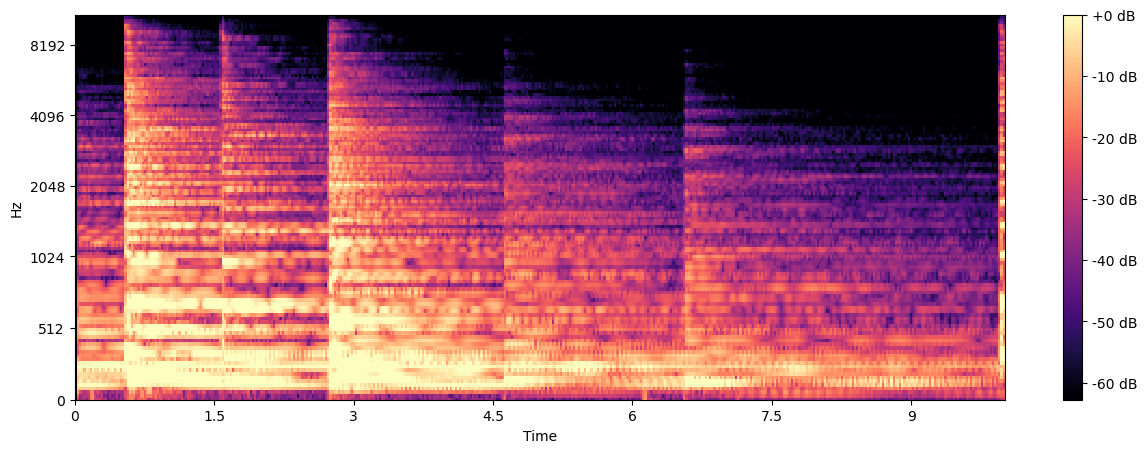

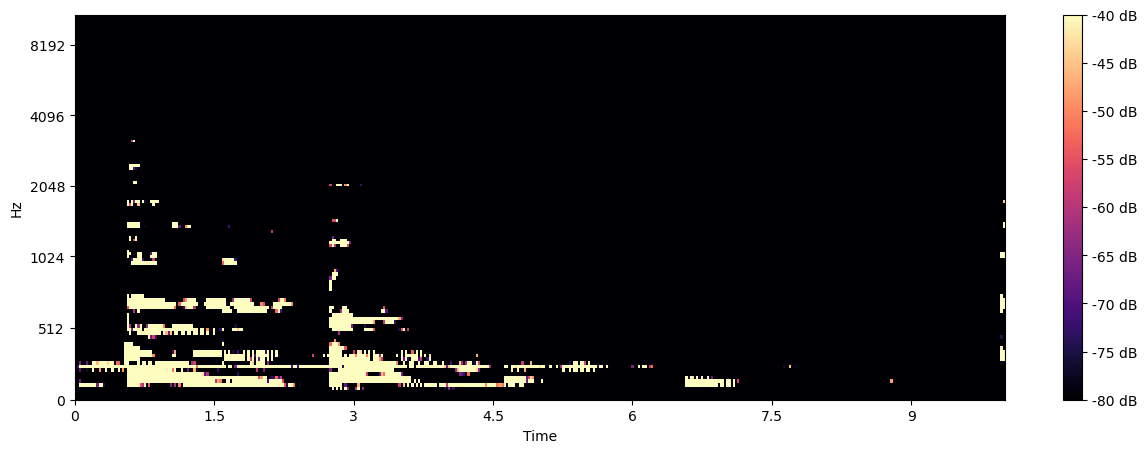

In [41]:
## Original
plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Recreated
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_hat, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [42]:
output = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output, rate=sr)

In [43]:
output = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S_hat),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output, rate=sr)